The goal of this notebook is to use MLFlow Experiment tracking and create a model that predicts the rental value of a property based on a few features. Problem definition: Predict the rental value of a property. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up MLflow

In [2]:
import mlflow

mlflow.set_tracking_uri("http://localhost:8090")
# mlflow.set_tracking_uri("sqlite:///mlflow.db") # Local Database
mlflow.set_experiment("rightmove-rent-prediction")

2024/01/29 10:38:15 INFO mlflow.tracking.fluent: Experiment with name 'rightmove-rent-prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1706524695369, experiment_id='1', last_update_time=1706524695369, lifecycle_stage='active', name='rightmove-rent-prediction', tags={}>

# Load data

We load data from our local mongo Server running on Docker Compose. 

In [3]:
from pymongo import MongoClient

def load_data_from_mongo(collection_name, fields):

    MONGO_URI = "mongodb://localhost:27017/"
    
    client = MongoClient(MONGO_URI) # Hosted with Docker

    db = client["rightmove"]

    # Access collection
    collection = db[collection_name]
    
    # fields = {"propertyImages": 1, "id": 1}
    query = {}
    
    # Fetch data from the collection
    data = collection.find(query, fields)
    
    # Convert to Pandas DataFrame
    df = pd.DataFrame(list(data))

    return df

In [4]:
fields = {"id": 1, "bedrooms": 1, "bathrooms":1, "location":1, "price":1}
df = load_data_from_mongo("properties", fields)
df = df.drop(columns=['_id', 'id'])

In [8]:
df.to_csv("property_data.csv")

We have 3 features to act as a baseline for our model. Number of bedrooms, bathrooms and location. Price will act as the target variable to predict.

In [5]:
df.head()

,bedrooms,bathrooms,location,price
0,2,1.0,"{'latitude': 57.156601, 'longitude': -2.10075}","{'amount': 700, 'frequency': 'monthly', 'curre..."
1,2,1.0,"{'latitude': 57.16631, 'longitude': -2.11688}","{'amount': 500, 'frequency': 'monthly', 'curre..."
2,2,1.0,"{'latitude': 57.15214, 'longitude': -2.0856}","{'amount': 850, 'frequency': 'monthly', 'curre..."
3,2,1.0,"{'latitude': 57.14584, 'longitude': -2.098261}","{'amount': 750, 'frequency': 'monthly', 'curre..."
4,2,2.0,"{'latitude': 57.15393, 'longitude': -2.09585}","{'amount': 850, 'frequency': 'monthly', 'curre..."


# EDA

## Preprocessing

We first need to standardize the target variable.

In [6]:
def convert_frequencies(x):
    frequency = x['frequency']
    price = x['amount']
    
    if frequency == 'monthly':
        return price * 12
    elif frequency == 'weekly':
        return (price / 7) * 365
    elif frequency == 'daily':
        return price * 365
    elif frequency == 'quarterly':
        return price * 4
    else: # Yearly
        return price

df['longitude'] = df['location'].apply(lambda x: x['longitude'])
df['latitude'] = df['location'].apply(lambda x: x['latitude'])

df = df.drop(columns=['location'])
df['price'] = df['price'].apply(convert_frequencies)

In [7]:
df.head()

,bedrooms,bathrooms,price,longitude,latitude
0,2,1.0,8400.0,-2.100750,57.156601
1,2,1.0,6000.0,-2.116880,57.166310
2,2,1.0,10200.0,-2.085600,57.152140
3,2,1.0,9000.0,-2.098261,57.145840
4,2,2.0,10200.0,-2.095850,57.153930


## Split Data

To prevent biases in our data analysis, we will split the data first, and then explore the training_val set. We want a test set to be completely unseen.

In [8]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your pandas DataFrame
train_val, test = train_test_split(df, test_size=0.2, random_state=42)  # 20% for test set
train, val = train_test_split(train_val, test_size=0.25, random_state=42)  # Splitting the remaining 80% into 60% training and 20% validation


In [9]:
train_val.head()

,bedrooms,bathrooms,price,longitude,latitude
18566,2,1.0,10800.000000,0.716820,52.032810
21265,4,1.0,27062.142857,-1.163420,52.961060
8607,3,2.0,11100.000000,-1.302500,53.496020
26266,1,1.0,5100.000000,-2.736508,52.060356
43690,1,1.0,19200.000000,-0.317519,51.515651


## Analysis

In [10]:
train_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50355 entries, 18566 to 56422
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   50355 non-null  int64  
 1   bathrooms  47401 non-null  float64
 2   price      50355 non-null  float64
 3   longitude  50355 non-null  float64
 4   latitude   50355 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 2.3 MB


In [11]:
train_val.describe()

,bedrooms,bathrooms,price,longitude,latitude
count,50355.000000,47401.000000,5.035500e+04,50355.000000,50355.000000
mean,2.368941,1.399000,2.766539e+04,-1.306509,52.410608
std,6.635001,1.113256,1.475869e+06,1.364034,1.376013
min,0.000000,0.000000,1.000000e+00,-7.629866,50.056373
25%,1.000000,1.000000,1.020000e+04,-2.241748,51.465842
50%,2.000000,1.000000,1.440000e+04,-1.263788,51.901180
75%,3.000000,2.000000,2.163929e+04,-0.172232,53.376778
max,1450.000000,75.000000,3.174174e+08,1.919810,58.520245


We can immediately spot anomalies such as a property with 1450 bedrooms, or another one with 75 bathrooms. 

In [12]:
df.isnull().sum()

bedrooms        0
bathrooms    3710
price           0
longitude       0
latitude        0
dtype: int64

Bathrooms are missing some values, I believe it will be a good indicator of value so it may be worth imputing the data.

array([[<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'bathrooms'}>],
       [<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'latitude'}>, <Axes: >]], dtype=object)

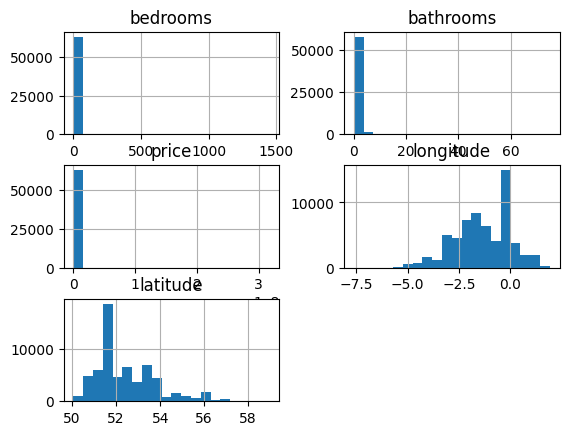

In [13]:
df.hist(bins=20)

Clearly the anomalies across all categories are heavily skewing the distribution of the data, need to handle them.

## Anomaly handling

### Bedrooms

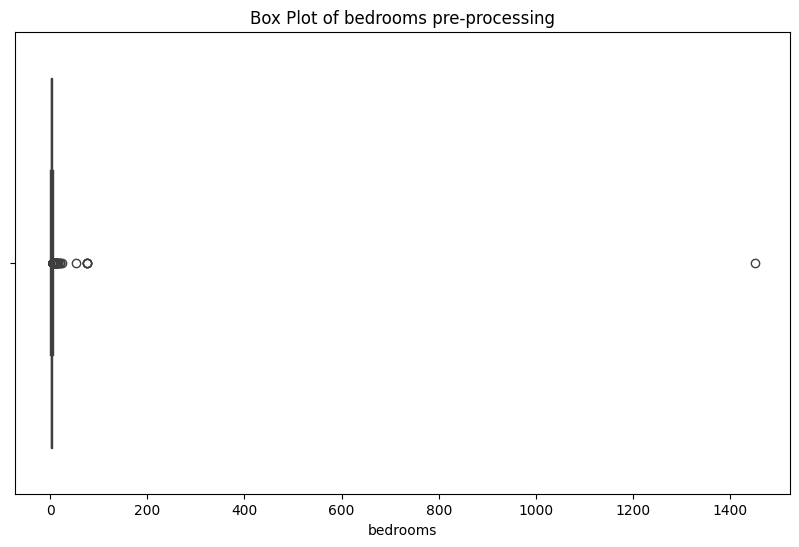

In [14]:
column = 'bedrooms'

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_val[column])
plt.title(f'Box Plot of {column} pre-processing')
plt.show()

In [15]:
train_val = train_val[train_val['bedrooms'] < 50]

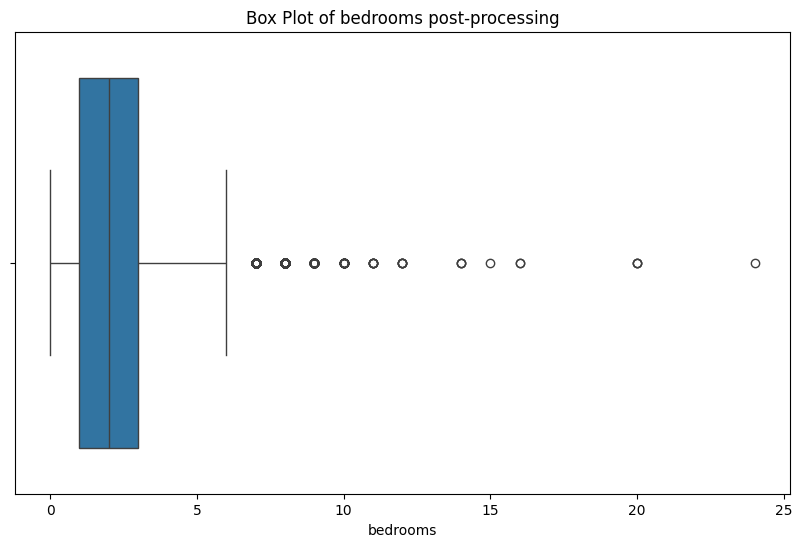

In [16]:
column = 'bedrooms'

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_val[column])
plt.title(f'Box Plot of {column} post-processing')
plt.show()

### Bathrooms

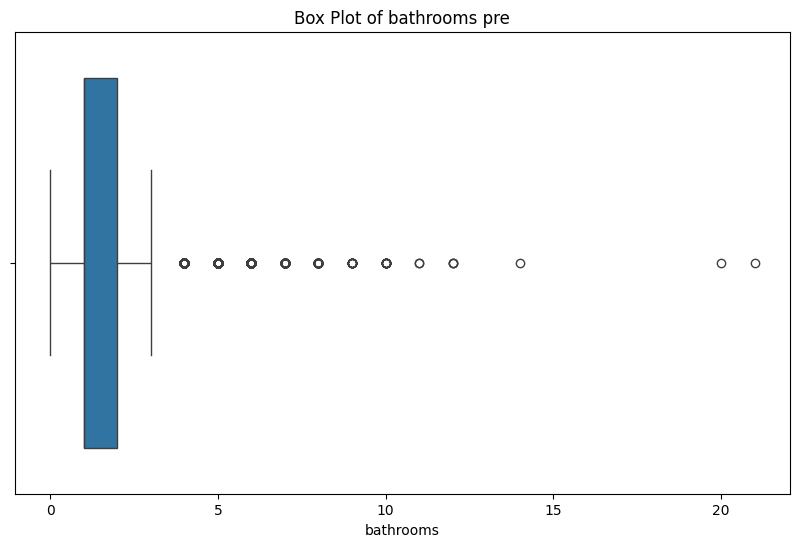

In [17]:
column = 'bathrooms'

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_val[column])
plt.title(f'Box Plot of {column} pre')
plt.show()

In [18]:
train_val = train_val[train_val['bathrooms'] < 18]

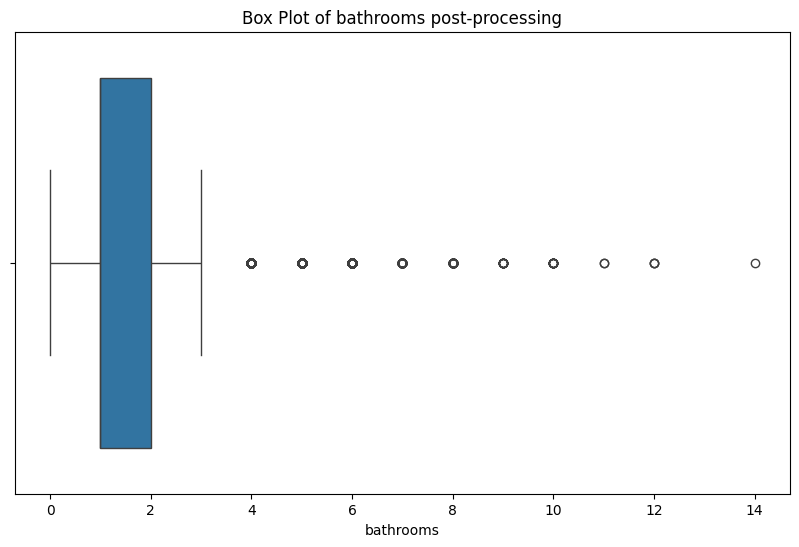

In [19]:
column = 'bathrooms'

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_val[column])
plt.title(f'Box Plot of {column} post-processing')
plt.show()

### Price

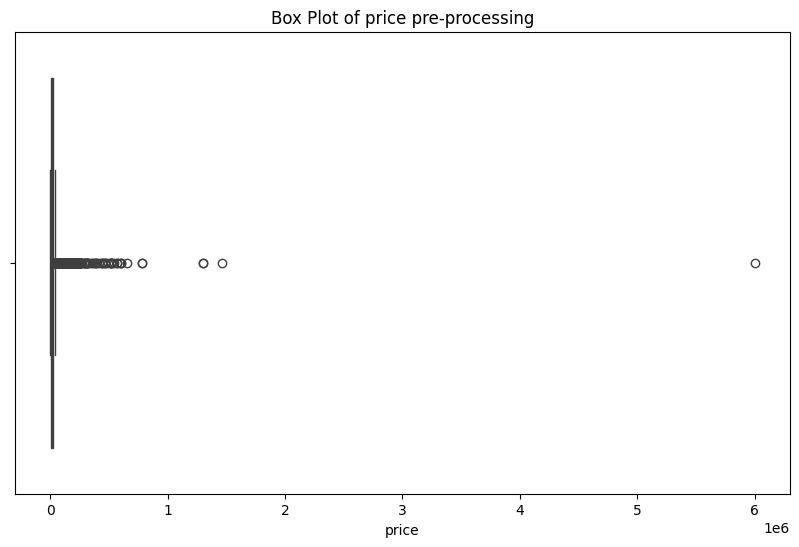

In [20]:
column = 'price'

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_val[column])
plt.title(f'Box Plot of {column} pre-processing')
plt.show()

In [21]:
train_val = train_val[train_val['price'] < 200_000]

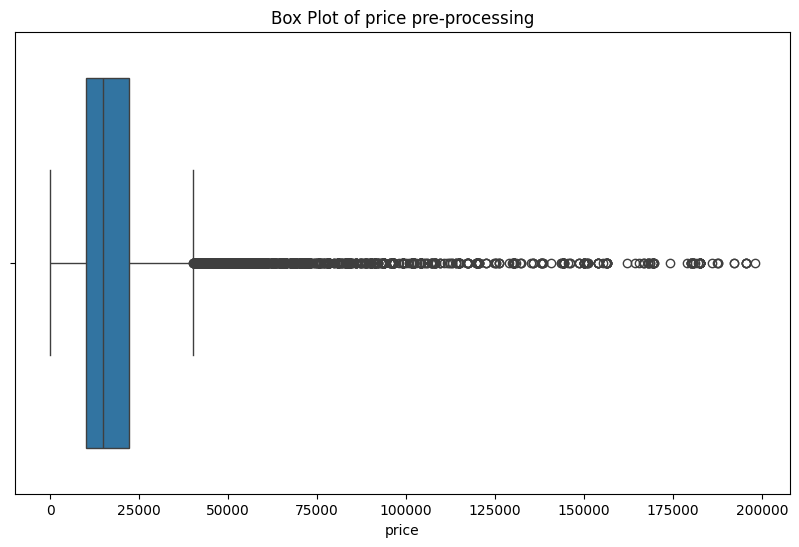

In [22]:
column = 'price'

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_val[column])
plt.title(f'Box Plot of {column} pre-processing')
plt.show()

array([[<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'bathrooms'}>],
       [<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'latitude'}>, <Axes: >]], dtype=object)

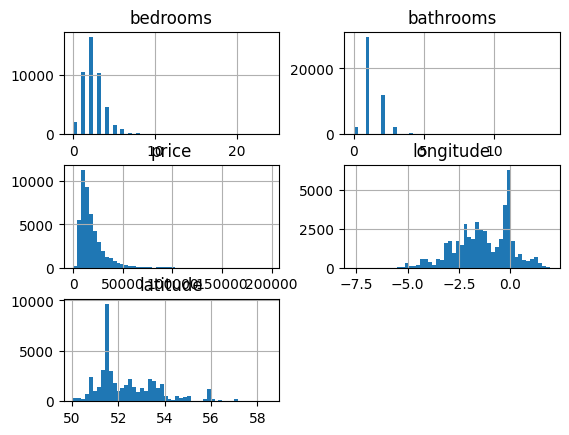

In [23]:
train_val.hist(bins=50)

In [24]:
def remove_anamolies(df):
    df = df[df['bedrooms'] < 50]
    df = df[df['bathrooms'] < 18]
    df = df[df['price'] < 1_000_000]

    return df

In [25]:
train_val = remove_anamolies(train_val)

## Correlation

In [26]:
train_val.corr()

,bedrooms,bathrooms,price,longitude,latitude
bedrooms,1.000000,0.516584,0.343976,-0.065098,0.005896
bathrooms,0.516584,1.000000,0.352840,0.025811,-0.033949
price,0.343976,0.352840,1.000000,0.244331,-0.272523
longitude,-0.065098,0.025811,0.244331,1.000000,-0.373363
latitude,0.005896,-0.033949,-0.272523,-0.373363,1.000000


The number of bathrooms and bedrooms are most correlate with price, which is no surpise given it is an indication of property size.

### Bathrooms and Bedrooms

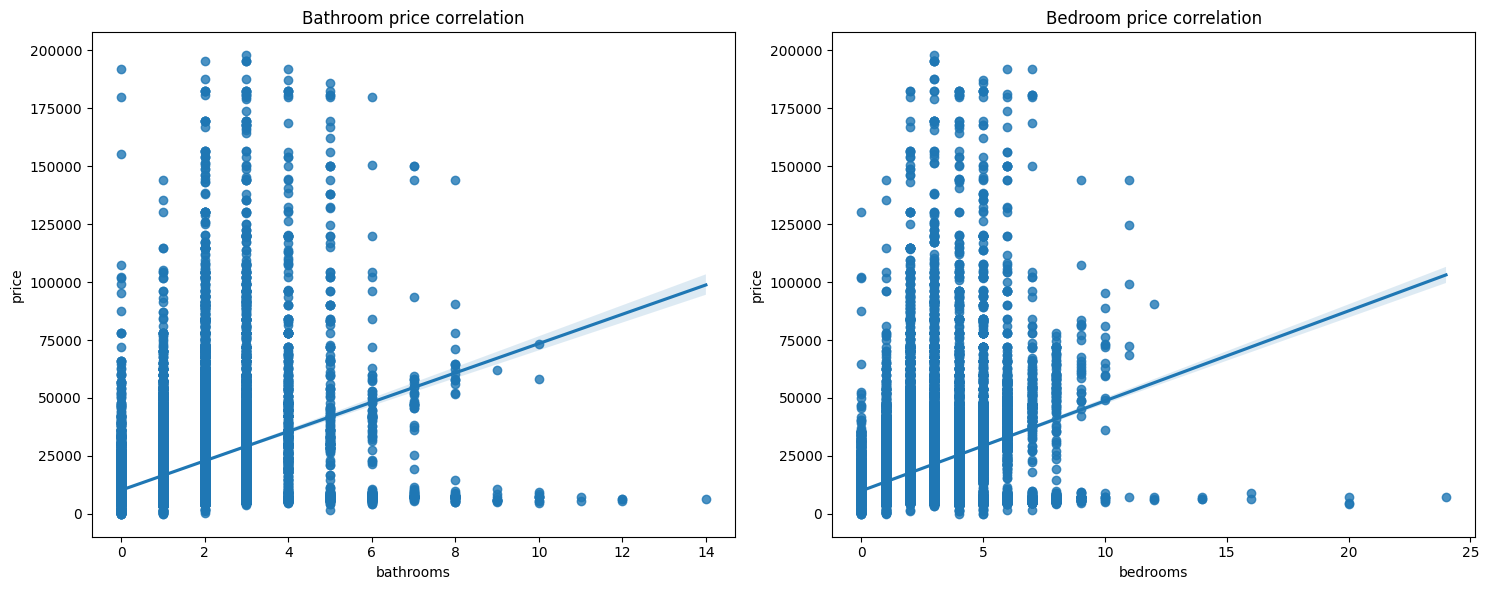

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))


axes[0].set_title("Bathroom price correlation")
sns.regplot(data=train_val, x="bathrooms", y="price", ax=axes[0])

axes[1].set_title("Bedroom price correlation")
sns.regplot(data=train_val, x="bedrooms", y="price", ax=axes[1])
                  
                  
plt.tight_layout()                  
plt.show()

## Imputting data

<Axes: title={'center': 'Bedroom price correlation'}, xlabel='bedrooms', ylabel='bathrooms'>

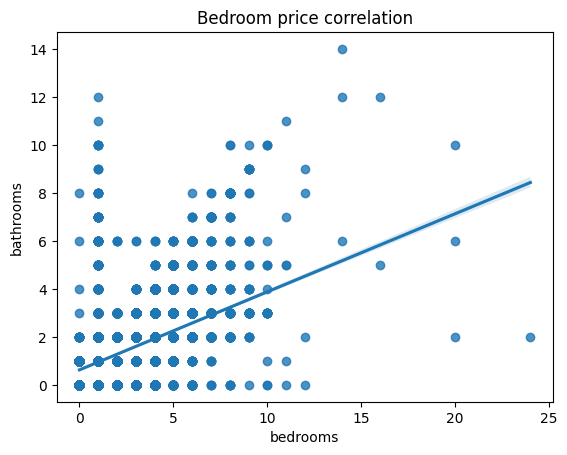

In [28]:
plt.title("Bedroom price correlation")
sns.regplot(data=train_val, x="bedrooms", y="bathrooms")

There is a relativaly strong correlation between the number of bedrooms and the number of bathrooms. So I believe imputting based on bedrooms will be best. 

## Drop rows

In [29]:
train_val = train_val.drop_duplicates()

In [30]:
train_val = train_val.dropna()

# Initial baseline model

In [31]:
X = train_val[['bedrooms', 'bathrooms', 'longitude', 'latitude']]
y = train_val['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)  # Splitting the remaining 80% into 60% training and 20% validation

### Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

We will use mean square error as our error metric as we are predicting continious values. 

In [33]:
# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [37]:
from mlflow.data.pandas_dataset import PandasDataset
dataset: PandasDataset = mlflow.data.from_pandas(df, source=dataset_source_url)

NameError: name 'dataset_source_url' is not defined

In [34]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Alex") # Addind metadata

    mlflow.log_param("Model type", "Linear Regression")

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric("rmse", rmse)

In [35]:
rmse

13376.51083272644

## RandomForest

In [129]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [134]:
rf = RandomForestRegressor()

# Initialize the GridSearchCV with RMSE as scoring metric
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

In [138]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [140]:
import numpy as np

In [141]:
with mlflow.start_run():

    # Fit the model on the training data
    rf.fit(X_train, y_train)

    # Get the best parameters from GridSearchCV
    # Make predictions on the test set
    y_pred = rf.predict(X_test)

    params = rf.get_params()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Log the best parameters and RMSE to MlFlow
    mlflow.log_params(params)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_param("Model type", "RandomForestRegressor")

    # Save the best model to MlFlow
    mlflow.sklearn.log_model(best_model, "RandomForestRegressorModel")

2024/01/26 14:45:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/6d/8tvwdn1n6j924gfrc5bg5h5rsn3bgj/T/tmpfwyx5gg3/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.3.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


In [149]:
def run_experiment(params):
    
    with mlflow.start_run(): 
            mlflow.log_params(params)
            rf = RandomForestRegressor(**params)
            rf.fit(X_train, y_train)
            # Make predictions on the test set
            y_pred = rf.predict(X_test)
        
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            print(f"Returned RMSE of {rmse}")
        
            # Log the best parameters and RMSE to MlFlow
            mlflow.log_metric("rmse", rmse)
        
            mlflow.log_param("Model type", "RandomForestRegressor")
        
            # Save the best model to MlFlow
            mlflow.sklearn.log_model(best_model, "RandomForestRegressorModel")

In [150]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [ ]:
run_experiment(ParameterGrid(param_grid)[0])

In [147]:
ParameterGrid(param_grid)[0]

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None}

In [ ]:
for params in ParameterGrid(param_grid):
    print(f"Starting experiment with params: {params}")
    run_experiment(params)

## Interpreting Random Forest

Based on MLFlow the most powerful model had:
max_depth	None
min_samples_leaf	2
min_samples_split	2
n_estimators	200

The resulting RMSE was 7865. Which considering the average yearly rental price is 18997 is fairly poor, because the variance in prediction will be way too large. 

In [160]:
best_params = {
    'n_estimators': 200,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

In [162]:
model = RandomForestRegressor(**best_params)

In [165]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

### Feature importance

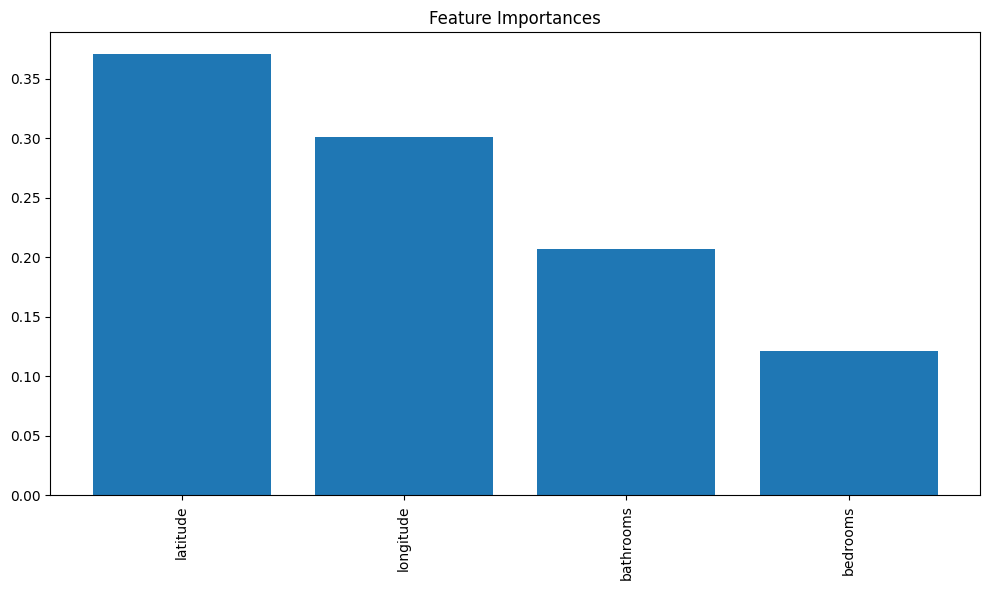

In [168]:
importances = model.feature_importances_
# Sort the feature importances in descending order
sorted_indices = importances.argsort()[::-1]
feature_names = X_train.columns

# Visualize the Feature Importancess
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

This is extremely fascinating, as it is implying that location are the most powerful preditors of rental value for a property. Which would be consistent with most research relating to property valuations. We can play around with developing some new features. 

# XGBoost

In [171]:
import xgboost as xgb

In [ ]:
xg_reg = xgb.XGBRegressor()

with mlflow.start_run():

    mlflow.set_tag("developer", "Alex") # Addind metadata

    mlflow.log_param("Model type", "XGboost")

    xg_reg = xgb.XGBRegressor()
    xg_reg.fit(X_train, y_train)
    
    y_pred = xg_reg.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric("rmse", rmse)

In [174]:
rmse

7810.196025656261

Unsurprisingly XGBoost performs better than other models. 

### Finetuning XGBoost

In [175]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [176]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [178]:
def objective(params):
    with mlflow.start_run(): # Start a new MLflow run for each evaluation
        mlflow.set_tag("Model type", "xgboost") # Log model tag
        mlflow.log_params(params) # Log parameters

        # Train the model
        booster = xgb.train(
            params=params,
            dtrain=train, # Your training dataset
            num_boost_round=1000,
            evals=[(valid, 'validation')], # Your validation dataset
            early_stopping_rounds=50
        )

        # Make predictions and calculate RMSE
        y_pred = booster.predict(valid) # Your validation dataset
        rmse = mean_squared_error(y_val, y_pred, squared=False) # y_val should be your validation target
        mlflow.log_metric("rmse", rmse) # Log RMSE metric

    return {'loss': rmse, 'status': STATUS_OK}

In [179]:
# Define the search space for Hyperopt
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror', # Updated objective for regression
    'seed': 42
}

In [ ]:
# Run Hyperopt
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

print("Best Hyperparameters:", best_result)

# Features

We will now add new features to our data and try and improve upon our model.

In [44]:
def convert_frequencies(x):
    frequency = x['frequency']
    price = x['amount']
    
    if frequency == 'monthly':
        return price * 12
    elif frequency == 'weekly':
        return (price / 7) * 365
    elif frequency == 'daily':
        return price * 365
    elif frequency == 'quarterly':
        return price * 4
    else: # Yearly
        return price

def remove_anamolies(df):
    df = df[df['bedrooms'] < 50]
    df = df[df['bathrooms'] < 18]
    df = df[df['price'] < 1_000_000]

    return df

def preprocess_data(df):
    df['longitude'] = df['location'].apply(lambda x: x['longitude'])
    df['latitude'] = df['location'].apply(lambda x: x['latitude'])

    df = df.drop_duplicates(subset='id')
    
    df = df.drop(columns=['_id', 'id', 'location'])
    
    df['price'] = df['price'].apply(convert_frequencies)

    df = remove_anamolies(df)

    df = df.dropna()

    return df

In [231]:
fields = {"id": 1, "bedrooms": 1, "bathrooms":1, "location":1, "price":1, "feature_list": 1, "commercial": 1, "development": 1, "students": 1, "summary": 1}
df = load_data_from_mongo(fields)

In [232]:
preprocessed_df = preprocess_data(df)

In [234]:
preprocessed_df

,bedrooms,bathrooms,summary,price,commercial,development,students,feature_list,longitude,latitude
0,2,1.0,SPRING TO KING'S CRESCENT! Bright and spacio...,8400.0,False,False,True,"[Modern throughout, Bright Spacious Rooms, Exc...",-2.100750,57.156601
1,2,1.0,Belvoir are pleased to offer for rental this f...,6000.0,False,False,False,"[Ultrafast Broadband Available, Green Space wi...",-2.116880,57.166310
2,2,1.0,We offer For Let this LUXURY 2 BEDROOM FULLY F...,10200.0,False,False,False,"[Stylish 2 Bedroom First Floor Apartment, Spac...",-2.085600,57.152140
3,2,1.0,Property Reference: 1898640.We are pleased to ...,9000.0,False,False,False,"[No Agent Fees, Students Can Enquire, Property...",-2.098261,57.145840
4,2,2.0,This ground floor property comprises of; entra...,10200.0,False,False,False,"[Double glazing, Shower, Washing machine, Tele...",-2.095850,57.153930
...,...,...,...,...,...,...,...,...,...,...
62937,1,0.0,A modern apartment located on the ground floo...,30936.0,False,False,False,"[Ground Floor Flat, 1 Bedroom, 1 Bathroom, Com...",-0.177018,51.533102
62938,0,1.0,This stylish studio apartment is on the 10th f...,24600.0,False,False,True,"[Pet Friendly, Roof Terrace, No Deposit Option...",-0.278890,51.558530
62939,3,2.0,A fabulous three bedroom two bathroom apartm...,24000.0,False,False,False,"[Spectacular City Centre Living, Three Double ...",-1.895690,52.487440
62941,6,0.0,CPH are DELIGHTED to offer to the RENTAL MARKE...,28800.0,False,False,False,"[SIX BEDROOM DETACHED HOUSE, OFF STREET PARKIN...",-0.442809,54.296051


# Handling textual Data

In [222]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [225]:
', '.join(['hello', 'world'])

'hello, world'

In [237]:
def merge_text(x):
    summary = x[0]
    feature_list = x[1]

    feature_list_joined = ', '.join(feature_list)

    return feature_list_joined + ' , ' + summary

In [238]:
preprocessed_df['text'] = preprocessed_df[['summary', 'feature_list']].apply(merge_text, axis=1)

In [241]:
preprocessed_df = preprocessed_df.drop(columns=['summary', 'feature_list'])

In [244]:
preprocessed_df['text']

0        Modern throughout, Bright Spacious Rooms, Exce...
1        Ultrafast Broadband Available, Green Space wit...
2        Stylish 2 Bedroom First Floor Apartment, Spaci...
3        No Agent Fees, Students Can Enquire, Property ...
4        Double glazing, Shower, Washing machine, Telev...
                               ...                        
62937    Ground Floor Flat, 1 Bedroom, 1 Bathroom, Comm...
62938    Pet Friendly, Roof Terrace, No Deposit Option,...
62939    Spectacular City Centre Living, Three Double B...
62941    SIX BEDROOM DETACHED HOUSE, OFF STREET PARKING...
62942    Semi-detached three bedroom family home, Kitch...
Name: text, Length: 51029, dtype: object

In [310]:
preprocessed_df['commercial'] = preprocessed_df['commercial'].apply(lambda x: 1 if x else 0)
preprocessed_df['development'] = preprocessed_df['development'].apply(lambda x: 1 if x else 0)
preprocessed_df['students'] = preprocessed_df['students'].apply(lambda x: 1 if x else 0)

## Split data

In [311]:
train_val, test = train_test_split(preprocessed_df, test_size=0.2, random_state=42)  # 20% for test set

In [312]:
train_val.head()

,bedrooms,bathrooms,price,commercial,development,students,longitude,latitude,text
16795,3,1.0,16200.0,0,0,0,-1.905006,50.812920,"Stunning three-bedroom house available now!, B..."
30951,2,0.0,12000.0,0,0,0,-0.533927,50.803699,"SPACIOUS FIRST FLOOR FLAT, TWO DOUBLE BEDROOMS..."
58701,1,1.0,7140.0,0,0,0,-0.488143,53.740456,"Quant Period Cottage, 1 Bedroom Character Prop..."
58258,3,1.0,10740.0,0,0,0,-1.275200,52.892870,"Available Now, Two Spacious Reception Rooms, G..."
21902,1,1.0,7200.0,0,0,0,-1.555076,54.531530,"No Agent Fees, Room Only (Shared House), Stude..."


In [345]:
numeric_features = ['bedrooms', 'bathrooms', 'longitude', 'latitude']
text_features = ['text']

X = train_val[numeric_features + text_features]
y = train_val['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)  # Splitting the remaining 80% into 60% training and 20% validation

In [346]:
X

,bedrooms,bathrooms,longitude,latitude,text
16795,3,1.0,-1.905006,50.812920,"Stunning three-bedroom house available now!, B..."
30951,2,0.0,-0.533927,50.803699,"SPACIOUS FIRST FLOOR FLAT, TWO DOUBLE BEDROOMS..."
58701,1,1.0,-0.488143,53.740456,"Quant Period Cottage, 1 Bedroom Character Prop..."
58258,3,1.0,-1.275200,52.892870,"Available Now, Two Spacious Reception Rooms, G..."
21902,1,1.0,-1.555076,54.531530,"No Agent Fees, Room Only (Shared House), Stude..."
...,...,...,...,...,...
14539,0,1.0,-1.781932,53.647977,"Town Centre Location, GWE & BB Bills Inclusive..."
55302,0,1.0,-0.093580,51.373760,"No deposit required, set utility fees*, Tech-e..."
47438,3,1.0,-1.189950,52.625860,"Council tax band A, Available 2024, 3 bedroom ..."
1025,5,3.0,-1.929790,52.438380,"Fully furnished with Double Beds, walking dist..."


In [347]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [348]:
numeric_features

['bedrooms', 'bathrooms', 'longitude', 'latitude']

In [349]:
preprocessor = ColumnTransformer(
    transformers=[
        # ('text', TfidfVectorizer(), 'text'),
        ('num', 'passthrough', numeric_features)
    ]
)

In [350]:
pipeline = Pipeline([
    ('transformer', preprocessor),
    ('classifier', xgb.XGBRegressor())
])

In [351]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['text'])

In [352]:
X_train

,bedrooms,bathrooms,longitude,latitude,text
39353,1,1.0,-0.241110,51.595570,"Selection of Amenities On-site, Well Tended Co..."
14871,2,2.0,-0.331732,51.562320,"No Agent Fees, Students Can Enquire, Property ..."
43096,2,1.0,-0.463023,51.347835,"CLOSE TO LOCAL AMENITIES AND HEALTH CLUB, NEAR..."
34038,3,1.0,1.163580,52.049090,"WATER VIEWS FROM ALL ROOMS, ONE ALLOCATED PARK..."
28185,0,1.0,0.340181,53.145110,"No Agent Fees, Students Can Enquire, Bills Inc..."
...,...,...,...,...,...
55415,2,2.0,-2.220842,53.480183,"**MUST SEE**, Ancoats location, Converted Mill..."
34829,3,1.0,-1.624322,54.687090,"No Agent Fees, Students Can Enquire, Property ..."
40917,1,1.0,-3.165760,51.467720,"FORIO HOUSE, ONE BEDROOM APARTMENT, FULLY FURN..."
41297,2,1.0,0.045880,51.583073,"No Agent Fees, Bills Included, Property Refere..."


In [353]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['bedrooms', 'bathrooms',
                                                   'longitude',
                                                   'latitude'])])),
                ('classifier',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [354]:
y_pred = pipeline.predict(X_val)

In [355]:
rmse = mean_squared_error(y_val, y_pred, squared=False)

In [356]:
rmse

11641.95877170567

# Walk Score

Location is clearly the most important indicator of a properties value, however coordinates, are not a good inidcator of how close your property is to town centers.  

In [37]:
fields = {"id": 1, "scores":1}
walk_score_df = load_data_from_mongo("walk_scores", fields)
walk_score_df = walk_score_df.drop(columns=['_id'])

In [33]:
walk_score_df['walk_score'] = walk_score_df['scores'].apply(lambda x: x['walk_score'])

In [38]:
fields = {"id": 1, "bedrooms": 1, "bathrooms":1, "location":1, "price":1}
property_df = load_data_from_mongo("properties", fields)
property_df = property_df.drop(columns=['_id'])

In [86]:
full_df = property_df.merge(walk_score_df, on='id')

In [89]:
full_df['scores'].iloc[0]

{'grocery': 2.9922318274989697,
 'restaurants': 2.2477573270328963,
 'shopping': 0.7292017742749498,
 'coffee': 1.9008371075608335,
 'banks': 0.1272753080779171,
 'parks': 0.6132279773053357,
 'schools': 0.8803189269738656,
 'books': 0.9579643579312742,
 'entertainment': 0.06415095371925339,
 'walk_score': 70.1214802877032}

In [92]:
full_df['walk_score'] = full_df['scores'].apply(lambda x: x['walk_score'])
full_df['restaurants'] = full_df['scores'].apply(lambda x: x['restaurants'])
full_df['shopping'] = full_df['scores'].apply(lambda x: x['shopping'])
full_df['coffee'] = full_df['scores'].apply(lambda x: x['coffee'])
full_df['banks'] = full_df['scores'].apply(lambda x: x['banks'])
full_df['parks'] = full_df['scores'].apply(lambda x: x['parks'])
full_df['schools'] = full_df['scores'].apply(lambda x: x['schools'])
full_df['books'] = full_df['scores'].apply(lambda x: x['books'])
full_df['entertainment'] = full_df['scores'].apply(lambda x: x['entertainment'])

In [49]:
def convert_frequencies(x):
    frequency = x['frequency']
    price = x['amount']
    
    if frequency == 'monthly':
        return price * 12
    elif frequency == 'weekly':
        return (price / 7) * 365
    elif frequency == 'daily':
        return price * 365
    elif frequency == 'quarterly':
        return price * 4
    else: # Yearly
        return price

def remove_anamolies(df):
    df = df[df['bedrooms'] < 50]
    df = df[df['bathrooms'] < 18]
    df = df[df['price'] < 1_000_000]

    return df

def preprocess_data(df):
    df['longitude'] = df['location'].apply(lambda x: x['longitude'])
    df['latitude'] = df['location'].apply(lambda x: x['latitude'])

    df = df.drop_duplicates(subset='id')
    
    df = df.drop(columns=['id', 'location', 'scores'])
    
    df['price'] = df['price'].apply(convert_frequencies)

    df = remove_anamolies(df)

    df = df.dropna()

    return df

In [93]:
preprocessed_df = preprocess_data(full_df)

In [117]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# numeric_features = ['bedrooms', 'bathrooms', 'longitude', 'latitude', 'walk_score', 'restaurants',
# 'shopping', 'coffee', 'banks', 'parks', 'schools', 'books', 'entertainment']

numeric_features = ['bedrooms', 'bathrooms', 'longitude', 'latitude', 'walk_score']
# text_features = ['text']

X = preprocessed_df[numeric_features]
y = preprocessed_df['price']

train_val, test = train_test_split(preprocessed_df[numeric_features + ['price']], test_size=0.2, random_state=42)  # 20% for test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)  # Splitting the remaining 80% into 60% training and 20% validation

In [100]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [101]:
from sklearn.metrics import mean_squared_error
import numpy as np 

y_pred = model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Returned RMSE of {rmse}")

Returned RMSE of 12751.977190191068


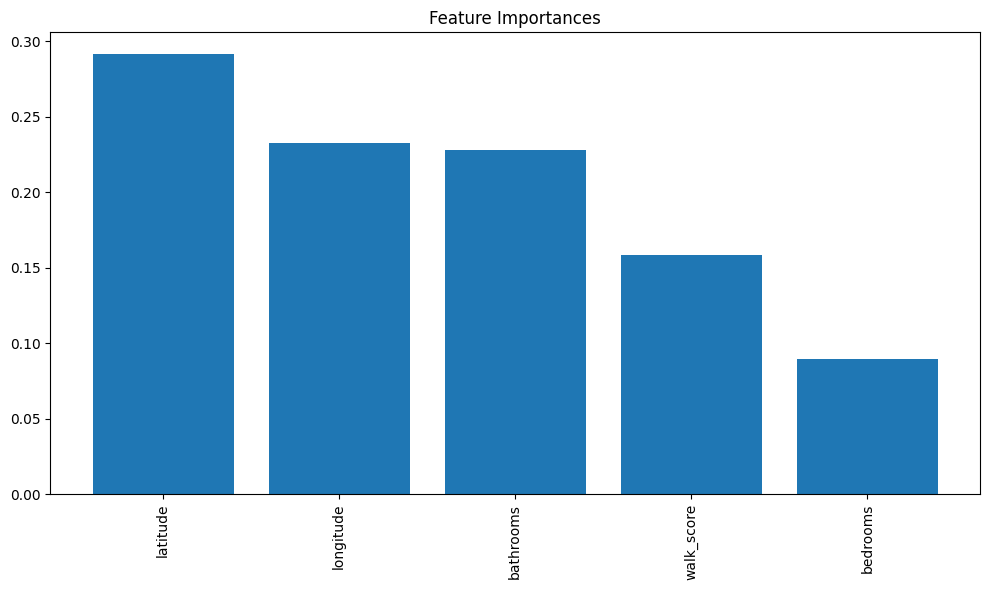

In [102]:
importances = model.feature_importances_
# Sort the feature importances in descending order
sorted_indices = importances.argsort()[::-1]
feature_names = X_train.columns

# Visualize the Feature Importancess
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [112]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train, y_train)

y_pred = xg_reg.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)

In [113]:
rmse

13003.569807524367

In [118]:
train_val.corr()

,bedrooms,bathrooms,longitude,latitude,walk_score,price
bedrooms,1.000000,0.530540,-0.056019,0.003694,-0.209332,0.284471
bathrooms,0.530540,1.000000,0.029698,-0.036012,-0.051528,0.330576
longitude,-0.056019,0.029698,1.000000,-0.376304,0.095851,0.187332
latitude,0.003694,-0.036012,-0.376304,1.000000,-0.092008,-0.203806
walk_score,-0.209332,-0.051528,0.095851,-0.092008,1.000000,0.109756
price,0.284471,0.330576,0.187332,-0.203806,0.109756,1.000000


In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='walk_score', ylabel='price'>

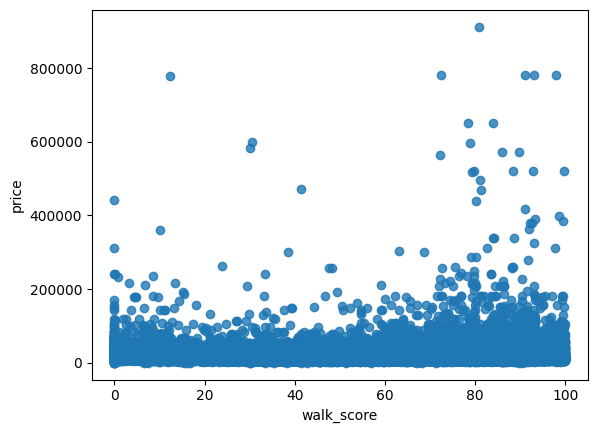

In [121]:
sns.regplot(data=train_val, x="walk_score", y="price")